In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

In [5]:
df_final = pd.read_csv("GOOGL_data.csv",na_values=['null'],index_col='date',parse_dates=True,infer_datetime_format=True)
df_final.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL


In [10]:
df_final.drop(df_final.columns[[5]], axis=1, inplace=True)
df_final.head()

,open,high,low,close,volume
date,,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199
2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781
2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176
2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946
2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971


In [11]:
df_final.shape

(1259, 5)

# Plotting the close column

<AxesSubplot:xlabel='date'>

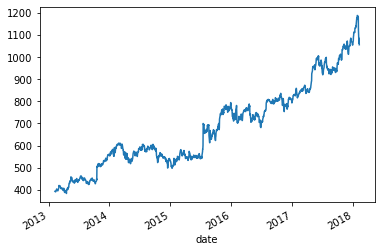

In [12]:
df_final['close'].plot()

# Correlating the features with close

In [13]:
D = df_final.drop(['close'],axis=1)

<AxesSubplot:title={'center':'Correlation with Close Feature'}>

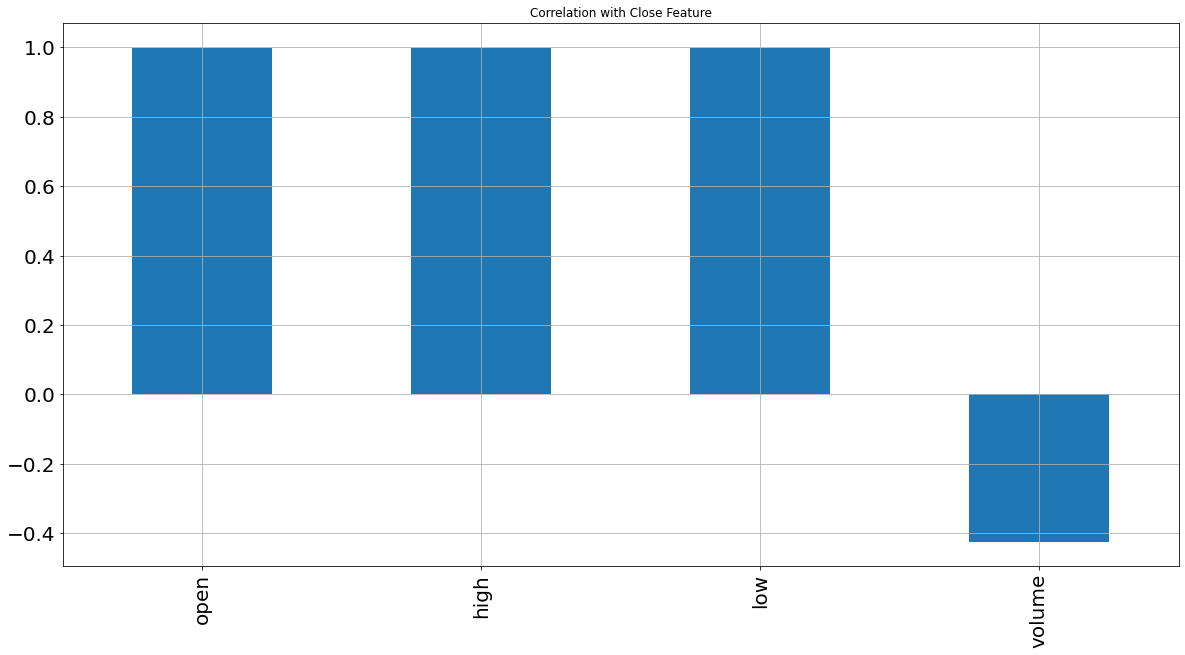

In [14]:
D.corrwith(df_final['close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Close Feature", fontsize = 20,
        rot = 90, grid = True)

In [16]:
#We can see that all other features except volume are positively correlated
test = df_final
# Target column
target = pd.DataFrame(test['close'])
display(test.head())

,open,high,low,close,volume
date,,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199
2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781
2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176
2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946
2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971


In [19]:
feature_columns = ['open', 'high', 'low', 'volume']

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,open,high,low,volume
date,,,,
2013-02-08,0.006837,0.004411,0.011405,0.243547
2013-02-11,0.005759,0.002137,0.007784,0.168388
2013-02-12,0.007847,0.005173,0.011287,0.141133
2013-02-13,0.006837,0.003593,0.011661,0.082779
2013-02-14,0.006588,0.005694,0.010290,0.130207


In [22]:
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)

Shape of features :  (1259, 4)
Shape of target :  (1259, 1)


In [24]:
target = target.shift(-1)
validation_y = target[-100:-1]
target = target[:-100]

In [26]:
validation_X = feature_minmax_transform[-100:-1]
feature_minmax_transform = feature_minmax_transform[:-100]
display(validation_X.tail())
display(validation_y.tail())

,open,high,low,volume
date,,,,
2017-09-21,0.701296,0.696473,0.695311,0.037550
2017-09-22,0.694621,0.693007,0.697123,0.024472
2017-09-25,0.690487,0.680318,0.676795,0.059769
2017-09-26,0.687050,0.685678,0.690007,0.050902
2017-09-27,0.694584,0.712107,0.698512,0.080157


,close
date,
2017-09-21,934.28
2017-09-22,937.43
2017-09-25,959.90
2017-09-26,964.81
2017-09-27,973.72


In [27]:
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)
display(target.tail())

Shape of features :  (1069, 4)
Shape of target :  (1069, 1)


,close
date,
2017-05-02,954.72
2017-05-03,950.28
2017-05-04,958.69
2017-05-05,956.71
2017-05-08,954.84


# Splitting into training and testing sets

In [28]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target[:len(train_index)].values.ravel(), target[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [29]:
X_train.shape

(972, 4)

In [30]:
y_train.shape

(972,)

In [31]:
X_test.shape

(97, 4)

In [32]:
y_test.shape

(97,)

# Processing the data

In [33]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Model making

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
122/122 [==============================] - 0s 3ms/step - loss: 378555.2188
Epoch 2/200
122/122 [==============================] - 0s 2ms/step - loss: 377470.2188
Epoch 3/200
122/122 [==============================] - 0s 2ms/step - loss: 375169.7188
Epoch 4/200
122/122 [==============================] - 0s 2ms/step - loss: 371223.9375
Epoch 5/200
122/122 [==============================] - 0s 2ms/step - loss: 365542.3750
Epoch 6/200
122/122 [==============================] - 0s 2ms/step - loss: 358293.4375
Epoch 7/200
122/122 [==============================] - 0s 2ms/step - loss: 349740.4375
Epoch 8/200
122/122 [==============================] - 0s 2ms/step - loss: 340138.4688
Epoch 9/200
122/122 [==============================] - 0s 2ms/step - loss: 329700.6562
Epoch 10/200
122/122 [==============================] - 0s 3ms/step - loss: 318597.5312
Epoch 11/200
122/122 [==============================] - 0s 2ms/step - loss: 306966.0625
Epoch 12/200
122/122 [===================

122/122 [==============================] - 0s 2ms/step - loss: 484.4026
Epoch 96/200
122/122 [==============================] - 0s 3ms/step - loss: 480.1003
Epoch 97/200
122/122 [==============================] - 0s 2ms/step - loss: 475.8184
Epoch 98/200
122/122 [==============================] - 0s 2ms/step - loss: 471.5578
Epoch 99/200
122/122 [==============================] - 0s 3ms/step - loss: 467.3206
Epoch 100/200
122/122 [==============================] - 0s 3ms/step - loss: 463.1087
Epoch 101/200
122/122 [==============================] - 0s 3ms/step - loss: 458.9223
Epoch 102/200
122/122 [==============================] - 0s 2ms/step - loss: 454.7637
Epoch 103/200
122/122 [==============================] - 0s 2ms/step - loss: 450.6333
Epoch 104/200
122/122 [==============================] - 0s 2ms/step - loss: 446.5328
Epoch 105/200
122/122 [==============================] - 0s 3ms/step - loss: 442.4625
Epoch 106/200
122/122 [==============================] - 0s 3ms/step - l

122/122 [==============================] - 0s 2ms/step - loss: 222.7961
Epoch 190/200
122/122 [==============================] - 0s 2ms/step - loss: 221.5810
Epoch 191/200
122/122 [==============================] - 0s 2ms/step - loss: 220.3961
Epoch 192/200
122/122 [==============================] - 0s 2ms/step - loss: 219.2413
Epoch 193/200
122/122 [==============================] - 0s 2ms/step - loss: 218.1162
Epoch 194/200
122/122 [==============================] - 0s 2ms/step - loss: 217.0207
Epoch 195/200
122/122 [==============================] - 0s 2ms/step - loss: 215.9547
Epoch 196/200
122/122 [==============================] - 0s 2ms/step - loss: 214.9178
Epoch 197/200
122/122 [==============================] - 0s 2ms/step - loss: 213.9096
Epoch 198/200
122/122 [==============================] - 0s 2ms/step - loss: 212.9301
Epoch 199/200
122/122 [==============================] - 0s 2ms/step - loss: 211.9789
Epoch 200/200
122/122 [==============================] - 0s 2ms/step

# Evaluation of lstm model

In [36]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	0.986
The R2 score on the Test set is:	0.873


In [37]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

97/97 [==============================] - 0s 1ms/step - loss: 165.3484


In [38]:
print('LSTM: %f'%score_lstm)

LSTM: 165.348434


In [41]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

# Plotting the predictions

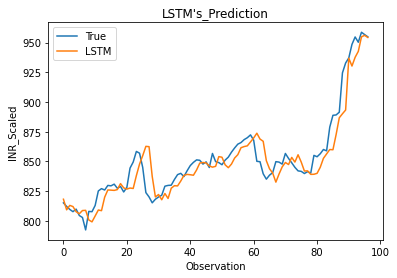

In [42]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()